In [66]:
import pandas as pd
from glob import glob
import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt
from io import StringIO
import re
import geoip2.database
import geoip2.errors

In [67]:
def span_attr(span, key):
    data = pd.DataFrame(span.at['attributes'])
    attr = data[data['key'] == key]
    if not attr.empty:
        return attr['value'].values[0]['stringValue']

In [68]:
def span_event(span, name):
    # print(span)
    # print(type(span))
    if 'events' not in span:
        return
    data = pd.DataFrame(span.at['events'])
    event = data[data['name'] == name]
    if not event.empty:
        return event.squeeze()

In [86]:
def report_traces(name):
    data = pd.read_json(f'{name}.json', orient='record')
    put_spans = data[data['name'] == 'KademliaDHT.ProtocolMessenger.PutProvider']
    put_peer_ids = [(span_attr(span, 'to'), span.at['status'] == {}) for _, span in put_spans.iterrows()]
    peer_addrs = {}
    for _, span in data[data['name'] == 'KademliaDHT.ProtocolMessenger.GetClosestPeers'].iterrows():
        span_peers = span_attr(span, 'peers')
        if not span_peers:
            continue
        span_peers = [
            re.match('{(\w*): \[([^\]]*)\]}', peer) 
            for peer in pd.read_json(StringIO(span_peers))[0].values]
        peer_addrs |= {peer[1]: peer[2].split() for peer in span_peers}
    # put_peer_addrs = {peer_id: (peer_addrs.get(peer_id), dialable) for peer_id, dialable in put_peer_ids}
    peer_countries = []
    with geoip2.database.Reader('GeoLite2-City.mmdb') as reader:
        for peer_id, dialable in put_peer_ids:
            addrs = peer_addrs.get(peer_id)
            if not addrs:
                print(f'! Peer addresses missing: {peer_id}')
                peer_countries.append(pd.Series(
                    {'peer id': peer_id, 'addrs': None, 'country': None, 'dialable': dialable}))
                continue
            country = None
            # print(addrs)
            for peer_addr in addrs:
                split = peer_addr.split('/')
                if split[1] != 'ip4':
                    continue
                try:
                    response = reader.city(split[2])
                except geoip2.errors.AddressNotFoundError:
                    continue
                country = response.country.name
                break
            if not country:
                print(f'! Contry not found for {addrs}')
            peer_countries.append(pd.Series({
                'peer id': peer_id, 'addrs': addrs, 'country': country, 'dialable': dialable}))
    # print(peer_countries)
    return peer_countries

In [87]:
data_sae = pd.DataFrame([
    record
    for name in glob('data.provide/traces.sae/*_other.json') 
    for record in report_traces(name.split('_')[0])])
data_apse = pd.DataFrame([
    record 
    for name in glob('data.provide/traces.apse/*_other.json') 
    for record in report_traces(name.split('_')[0])])

! Contry not found for ['/ip6/::1/udp/4001/quic', '/ip4/127.0.0.1/tcp/4001', '/ip6/::1/tcp/4001', '/ip4/127.0.0.1/udp/4001/quic']
! Contry not found for ['/ip4/127.0.0.1/udp/4001/quic', '/ip6/::1/tcp/4001', '/ip6/::1/udp/4001/quic', '/ip4/127.0.0.1/tcp/4001']
! Contry not found for ['/ip6/::1/tcp/4001', '/ip6/::1/udp/4001/quic', '/ip4/127.0.0.1/tcp/4001', '/ip4/127.0.0.1/udp/4001/quic']
! Contry not found for ['/ip4/127.0.0.1/tcp/4001', '/ip4/127.0.0.1/udp/4001/quic', '/ip6/::1/tcp/4001', '/ip6/::1/udp/4001/quic']
! Contry not found for ['/ip6/::1/udp/4001/quic', '/ip6/::1/tcp/4001', '/ip4/127.0.0.1/udp/4001/quic', '/ip4/127.0.0.1/tcp/4001']
! Contry not found for ['/ip6/::1/udp/4001/quic', '/ip4/127.0.0.1/udp/4001/quic', '/ip6/::1/tcp/4001', '/ip4/127.0.0.1/tcp/4001']
! Contry not found for ['/ip4/104.18.6.145/tcp/4001', '/ip4/20.203.114.251/tcp/10688', '/ip4/20.174.40.142/tcp/4001', '/ip4/20.203.114.251/tcp/10689']
! Contry not found for ['/ip6/::1/udp/4001/quic', '/ip6/::1/tcp/4001'

In [88]:
data_sae['dialable'].value_counts()

dialable
True     1841
False     159
Name: count, dtype: int64

In [89]:
data_apse['dialable'].value_counts()

dialable
True     1873
False     187
Name: count, dtype: int64

In [101]:
for _, row in data_sae[~data_sae['dialable'] & data_sae['country'].isnull()].iterrows():
    print(row.at['addrs'])

['/ip4/127.0.0.1/udp/4001/quic', '/ip6/::1/tcp/4001', '/ip6/::1/udp/4001/quic', '/ip4/127.0.0.1/tcp/4001']
['/ip4/127.0.0.1/tcp/4001', '/ip4/127.0.0.1/udp/4001/quic', '/ip6/::1/tcp/4001', '/ip6/::1/udp/4001/quic']
['/ip4/192.168.1.13/tcp/44005', '/ip4/127.0.0.1/tcp/44005', '/ip6/::1/tcp/44005']


In [102]:
for _, row in data_sae[~data_sae['dialable'] & ~data_sae['country'].isnull()].iterrows():
    print(row.at['country'], row.at['addrs'])

China ['/ip4/60.163.54.80/tcp/42515', '/ip6/240e:390:484e:2840:ba36:3985:277:e63f/udp/4001/quic-v1', '/ip6/240e:390:484e:2840:ba36:3985:277:e63f/udp/4001/quic-v1/webtransport/certhash/uEiBV6ZjUMSFM7GlOjYxcOdy2AVdoHKuXplRwadKooj1ghA/certhash/uEiBWDuz8KmWMCvmEKZJ-DMFzaFhE4STWtOcxGPxiKzgsyA', '/ip6/240e:390:484e:2840:ba36:3985:277:e63f/tcp/4001', '/ip6/240e:390:484e:2840:ba36:3985:277:e63f/tcp/42515']
United States ['/ip4/108.4.150.104/udp/48419/quic-v1', '/ip6/::1/udp/44004/quic-v1/webtransport/certhash/uEiCVr-MaudNbhMLTG6odktnvO1LOaiW3kbpbXj2j_uV50Q/certhash/uEiDEERlXE77iuKj0MAPf05aV-_ptwRpSGv0kMkOEchhfjA', '/ip4/127.0.0.1/udp/44004/quic-v1', '/ip4/192.168.1.228/udp/44004/quic-v1', '/ip6/::1/udp/44004/quic-v1', '/ip4/127.0.0.1/udp/44004/quic-v1/webtransport/certhash/uEiCVr-MaudNbhMLTG6odktnvO1LOaiW3kbpbXj2j_uV50Q/certhash/uEiDEERlXE77iuKj0MAPf05aV-_ptwRpSGv0kMkOEchhfjA', '/ip4/108.4.150.104/udp/48419/quic-v1/webtransport/certhash/uEiCVr-MaudNbhMLTG6odktnvO1LOaiW3kbpbXj2j_uV50Q/certhash/

In [105]:
for _, row in data_apse[~data_sae['dialable'] & ~data_apse['country'].isnull()].iterrows():
    print(row.at['country'], row.at['addrs'])

South Korea ['/ip4/158.247.208.35/udp/4001/quic-v1', '/ip4/127.0.0.1/udp/4001/quic-v1', '/ip4/127.0.0.1/udp/4001/quic', '/ip4/127.0.0.1/udp/4001/quic-v1/webtransport/certhash/uEiCz1adT4Vox5vaMZge9LNB9wyB8EsCBpMSlfh8qXaCtkw/certhash/uEiANCNbjQTF37qcsozpbhx5f1u2xlpXLF8ZwMs2DqzCpIw', '/ip6/::1/udp/4001/quic-v1/webtransport/certhash/uEiCz1adT4Vox5vaMZge9LNB9wyB8EsCBpMSlfh8qXaCtkw/certhash/uEiANCNbjQTF37qcsozpbhx5f1u2xlpXLF8ZwMs2DqzCpIw', '/ip6/::1/tcp/4001', '/ip4/127.0.0.1/tcp/4001', '/ip4/158.247.208.35/udp/4001/quic', '/ip6/::1/udp/4001/quic-v1', '/ip6/::1/udp/4001/quic']
United States ['/ip4/127.0.0.1/udp/4001/quic', '/ip4/127.0.0.1/tcp/4001', '/ip6/::1/udp/4001/quic', '/ip6/::1/tcp/4001', '/ip4/207.148.13.218/udp/4001/quic']
Germany ['/ip4/161.97.112.86/tcp/4001', '/ip4/161.97.112.86/udp/4001/quic', '/ip4/127.0.0.1/udp/4001/quic', '/ip6/::1/tcp/4001', '/ip4/127.0.0.1/tcp/4001', '/ip6/::1/udp/4001/quic']
United States ['/ip4/127.0.0.1/udp/4001/quic', '/ip6/::1/udp/4001/quic-v1/webtrans

([<matplotlib.patches.Wedge at 0x7f6fbcbb0af0>,
 [Text(0.23424113179133133, 1.0747702508802133, 'United States'),
  Text(-1.0978999574653194, -0.06793882099102175, 'Germany'),
  Text(-0.8212391320635591, -0.7318239460194591, 'South Korea'),
  Text(-0.5269477931779712, -0.9655703098505392, 'United Kingdom'),
  Text(-0.2287027835058945, -1.075962377045153, 'France'),
  Text(0.011330214277318538, -1.099941646745149, 'Japan'),
  Text(0.20463538163132453, -1.0807980202538319, 'The Netherlands'),
  Text(0.3703010938181374, -1.035797808414891, 'Singapore'),
  Text(0.5169744930544938, -0.9709466378390985, 'Canada'),
  Text(0.6358232482565461, -0.8976239730402117, 'Thailand'),
  Text(0.7332327067641099, -0.8199815837757437, 'China'),
  Text(0.8098346652483845, -0.7444244857351464, 'Finland'),
  Text(0.867199278831436, -0.6767314170291175, 'Australia'),
  Text(0.9136976013119883, -0.6125003619237454, 'Sweden'),
  Text(0.9488287803250084, -0.5565284769236495, 'Russia'),
  Text(0.9753483900251886,

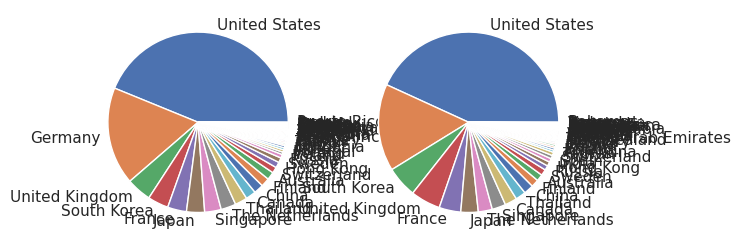

In [73]:
countries_apse = data_apse[data_apse['dialable']]['country'].value_counts()
countries_sae = data_sae[data_sae['dialable']]['country'].value_counts()
plt.subplot(1, 2, 1)
plt.pie(countries_apse, labels=countries_apse.index)
plt.subplot(1, 2, 2)
plt.pie(countries_sae, labels=countries_sae.index)

*Backup experiment cells*

In [41]:
data = pd.read_json('data.provide/traces.apse/2024-03-14T11:39:58.515507213Z.json', orient='record')
other_data = pd.read_json('data.provide/traces.apse/2024-03-14T11:39:58.515507213Z_other.json', orient='record')

In [47]:
put_spans = data[data['name'] == 'KademliaDHT.ProtocolMessenger.PutProvider']
put_spans[put_spans['status'] != {}]

,traceId,spanId,parentSpanId,name,kind,startTimeUnixNano,endTimeUnixNano,attributes,status
90,7DNZGbu4xMVyt3luhHJmGQ==,9wo7vB0JiVw=,8XunL7vv7us=,KademliaDHT.ProtocolMessenger.PutProvider,SPAN_KIND_INTERNAL,1710416404275882496,1710416404276089088,"[{'key': 'to', 'value': {'stringValue': '12D3K...",{'message': 'failed to dial: failed to dial 12...
94,7DNZGbu4xMVyt3luhHJmGQ==,cD2a2a2cFtM=,8XunL7vv7us=,KademliaDHT.ProtocolMessenger.PutProvider,SPAN_KIND_INTERNAL,1710416404273803008,1710416404276914944,"[{'key': 'to', 'value': {'stringValue': '12D3K...",{'message': 'failed to dial: failed to dial 12...
95,7DNZGbu4xMVyt3luhHJmGQ==,zhzHGkuiU8Q=,8XunL7vv7us=,KademliaDHT.ProtocolMessenger.PutProvider,SPAN_KIND_INTERNAL,1710416404274694400,1710416404277779712,"[{'key': 'to', 'value': {'stringValue': '12D3K...",{'message': 'failed to dial: failed to dial 12...


In [42]:
put_spans = data[data['name'] == 'KademliaDHT.ProtocolMessenger.PutProvider']
put_peer_ids = [span_attr(span[1], 'to') for span in put_spans.iterrows()]
put_peer_ids

['12D3KooWCmyQQqaXgS53nXBEzNZZda69tPbHJXDLknH5cWQrsXv1',
 '12D3KooWNMHDEuLZw3W22AikSo7m2tudvNbjmGtDhrQ69agAqJMU',
 '12D3KooWKhDwH57dPwjPAuFHDQWkr44gPSrpHu4KVUrnNe6AdYxe',
 '12D3KooWAph85HjPr8gja8pJ7jpBPNPbURY2mAHouH1gdRkQmKza',
 'QmcDFzKUACfgfyHn2TTuwxrENRhmFZ4Ceqo6xRD24Ma8pX',
 'QmW3QAbiZbsi95YkYG4S7BBJbudJ9X1W2fLxdvsbAxjouE',
 '12D3KooWEnGGZHPUXzEerTqtFFvCHxJXsXFSiAFzVTzyMg2SRBER',
 '12D3KooW9vsbspGGJKxsWVMG7ydT6P9Dznh7SwZP85Rc6GuFaT8A',
 '12D3KooWJ4zCGAktevjez4GVj6ygCuQig2tphbTDB7TPWwLHDVmf',
 '12D3KooWMU92LuH51tdnMcbQuxG57njsj27XPb5HLSqCXUhXXExk',
 '12D3KooWGuYNtA89MCnHJoJfLYKsxVEBMj68CaRUzwMhWxmMFYb7',
 '12D3KooWC7X15XmDayCoKqcgKgYYX7DjTF8e3GZeMBhTS7EW8f5h',
 '12D3KooWFm5SfqLWewE8utzzPbV19ai3AQXAB5itDaZFcViuSPP7',
 '12D3KooWFL1PNyR5mcjYqRa9AeEAvta3J6ynMWNWp1Jv3E7dZZJg',
 '12D3KooWSPPKU4jss6v2iLMXcKqSRZv1ENmFrW9gkNCR1SPodWEf',
 '12D3KooWNbgpoXTeU6nhPZzbRiFP1ywtLc8PUv2FNF1p1vjHFaAs',
 '12D3KooWG9Ambppjv8fWENGVdj5quoeRZ5p3DDuE3YaJjtDyLQ35',
 '12D3KooWStuDzhf4iBBFW8ZqUKMfKWRZ7cYfPvxTy

In [27]:
def dial_put_peer(span):
    return span.at['name'] == 'KademliaDHT.IpfsDHT.DialPeer'
other_data[other_data.apply(dial_put_peer, axis=1)].loc[13]['attributes']

[{'key': 'PeerID',
  'value': {'stringValue': '12D3KooWANiNstQreaW8S2HHbi6ziDJmdi4xT4xMGMHpb1Jmcb2n'}},
 {'key': 'internal.span.format', 'value': {'stringValue': 'otlp'}}]

In [ ]:
peer_addrs = span_attr(data[data['name'] == 'KademliaDHT.ProtocolMessenger.GetClosestPeers'].loc[14], 'peers')
peer_addrs = pd.read_json(StringIO(peer_addrs))[0].values
peer_addrs = [re.match('{(\w*): \[([^\]]*)\]}', peer) for peer in peer_addrs]
peer_addrs
peer_addrs = {peer[1]: peer[2].split() for peer in peer_addrs}
peer_addrs

In [75]:
peer_addrs = {}
for _, span in data[data['name'] == 'KademliaDHT.ProtocolMessenger.GetClosestPeers'].iterrows():
    span_peers = span_attr(span, 'peers')
    if not span_peers:
        continue
    span_peers = [
        re.match('{(\w*): \[([^\]]*)\]}', peer) 
        for peer in pd.read_json(StringIO(span_peers))[0].values]
    peer_addrs |= {peer[1]: peer[2].split() for peer in span_peers}
peer_addrs

{'12D3KooWNMHDEuLZw3W22AikSo7m2tudvNbjmGtDhrQ69agAqJMU': ['/ip4/158.247.206.118/udp/4001/quic',
  '/ip4/158.247.206.118/udp/4001/quic-v1',
  '/ip4/158.247.206.118/tcp/4001'],
 '12D3KooWKhDwH57dPwjPAuFHDQWkr44gPSrpHu4KVUrnNe6AdYxe': ['/ip4/108.61.178.245/udp/4001/quic',
  '/ip4/108.61.178.245/udp/4001/quic-v1/webtransport/certhash/uEiAwawW_Vw3XhesCgQm_Cn5sy5v8QKYdl3gwYNyjg1qUzA/certhash/uEiDWjFe7ZVqwXZCFGr_eFARL7CQqAjojk72eok5oeYvvfw',
  '/ip4/108.61.178.245/udp/4001/quic-v1'],
 'QmcDFzKUACfgfyHn2TTuwxrENRhmFZ4Ceqo6xRD24Ma8pX': ['/ip4/210.113.236.100/tcp/41417'],
 'QmW3QAbiZbsi95YkYG4S7BBJbudJ9X1W2fLxdvsbAxjouE': ['/ip4/219.79.46.98/tcp/42688'],
 '12D3KooWEnGGZHPUXzEerTqtFFvCHxJXsXFSiAFzVTzyMg2SRBER': ['/ip4/107.173.125.22/udp/4001/quic-v1',
  '/ip4/107.173.125.22/udp/4001/quic-v1/webtransport/certhash/uEiD8CnjnCLZXhGgL0MXZ3aTnsm6aD6NjyvCxHCGkhn6raw/certhash/uEiDSsWbfmXGhd6hrUjtZH3s90EYRpXwO-GJaP-kIWgiJsg'],
 '12D3KooW9vsbspGGJKxsWVMG7ydT6P9Dznh7SwZP85Rc6GuFaT8A': ['/ip4/67.22.44.69/tcp

In [76]:
put_peer_addrs = [peer_addrs.get(peer_id) for peer_id in put_peer_ids]
put_peer_addrs

[['/ip4/149.28.95.188/udp/4001/quic-v1',
  '/ip4/149.28.95.188/udp/4001/quic',
  '/ip4/149.28.95.188/tcp/4001'],
 ['/ip4/158.247.206.118/udp/4001/quic',
  '/ip4/158.247.206.118/udp/4001/quic-v1',
  '/ip4/158.247.206.118/tcp/4001'],
 ['/ip4/108.61.178.245/udp/4001/quic',
  '/ip4/108.61.178.245/udp/4001/quic-v1/webtransport/certhash/uEiAwawW_Vw3XhesCgQm_Cn5sy5v8QKYdl3gwYNyjg1qUzA/certhash/uEiDWjFe7ZVqwXZCFGr_eFARL7CQqAjojk72eok5oeYvvfw',
  '/ip4/108.61.178.245/udp/4001/quic-v1'],
 ['/ip4/148.135.39.38/udp/4001/quic-v1',
  '/ip4/148.135.39.38/udp/4001/quic',
  '/ip4/148.135.39.38/udp/4001/quic-v1/webtransport/certhash/uEiD1-fwvi6NSsiwEp8Iz1qSD0Y9I4RbR9H-NTIylhYi28g/certhash/uEiAA9dII0ArKRX3AeKv6sbx1iQlUeVifvmut1eXjreHUPw'],
 ['/ip4/210.113.236.100/tcp/41417'],
 ['/ip4/219.79.46.98/tcp/42688'],
 ['/ip4/107.173.125.22/udp/4001/quic-v1',
  '/ip4/107.173.125.22/udp/4001/quic-v1/webtransport/certhash/uEiD8CnjnCLZXhGgL0MXZ3aTnsm6aD6NjyvCxHCGkhn6raw/certhash/uEiDSsWbfmXGhd6hrUjtZH3s90EYRpXwO-GJa

In [94]:
peer_countries = {}
with geoip2.database.Reader('GeoLite2-City.mmdb') as reader:
    for peer_addrs in put_peer_addrs:
        country = None
        for peer_addr in peer_addrs:
            split = peer_addr.split('/')
            if split[1] != 'ip4':
                continue
            try:
                response = reader.city(split[2])
            except geoip2.errors.AddressNotFoundError:
                continue
            country = response.country.name
        if not country:
            print(f'! Contry not found for {peer_addrs}')
        else:
            peer_countries[country] = peer_countries.get(country, 0) + 1
peer_countries

{'United States': 8,
 'South Korea': 2,
 'Germany': 2,
 'Hong Kong': 1,
 'The Netherlands': 2,
 'France': 1,
 'Australia': 1,
 'Finland': 1,
 'Singapore': 1,
 'Romania': 1}